# Дисклеймер
Эту тетрадку нужно запускать в колабе. Не мучатесь с установкой библиотек и с обучением на cpu.

In [2]:
# %pip install --upgrade keras
# %pip install torch torchvision torchaudio

## Рекуррентные нейронные сети

Рекуррентные нейронные сети (RNN) предназначены для работы с последовательностями (в том числе текстом). По устройству они похожи на цикл, где каждый шаг связан с предудущими через внешние переменные, в которые записывается нужная информация по каким-то условиям. Так как в рекурентных сетях вычисления происходят последовательно, обучение плохо поддается параллелизации. Простыми словами, рекурректные сети медленные. Но их неэффективность часто компенсируется точностью, поэтому рекурректные сети - это стандартный инструмент при работе с текстами.  

## Классификация текста с помощью RNN

Давайте посмотрим, как в тензорфлоу использовать рекуррентные слои и как их соединять с Embedding и Dense слоями.

## Код с прошлых занятий

In [3]:
# в новой версии кераса можно использовать разные бекэнды, можно попробовать торч
# если заменить на tensorflow или jax то код также будет работать
# но нужно заранее установить нужный фреймворк
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.0.5


In [5]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
# from IPython.display import Image
# from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

Возьмем небольшой кусок датасета [lenta.ru](https://github.com/yutkin/Lenta.Ru-News-Dataset). Попробуем предсказывать тематику текста

In [8]:
data = pd.read_csv('../../data/lenta_40k.csv.zip')

In [9]:
data.head(5)

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия


In [10]:
data.topic.unique()

array(['Спорт', 'Мир', 'Интернет и СМИ', 'Россия', 'Наука и техника',
       'Силовые структуры', 'Бывший СССР', 'Культура', 'Экономика',
       'Ценности', 'Из жизни', 'Дом', 'Бизнес', '69-я параллель', 'Крым',
       'Путешествия', 'Культпросвет ', 'Легпром', 'Библиотека'],
      dtype=object)

Предобработка нам тут особо не важна.

In [11]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

Как и раньше, создаем словарь, фильтруем, чтобы он был адекватного размера и переводим токены в индексы

In [12]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [13]:
len(vocab)

354611

In [14]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [15]:
len(filtered_vocab)

24091

In [16]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [17]:
id2word = {i:word for word, i in word2id.items()}

In [18]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [19]:
MAX_LEN = max(len(x) for x in X)

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [20]:
MEAN_LEN = np.median([len(x) for x in X])

In [21]:
MAX_LEN, MEAN_LEN

(1748, 170.0)

In [22]:
MAX_LEN = int(MEAN_LEN + 30)

In [23]:
# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [24]:
X.shape

(44356, 200)

In [25]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [26]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [27]:
len(label2id)

19

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

Есть несколько разновидностей рекуррентных слоев - RNN (vanila rnn), GRU, LSTM. 

Первый - самый простой рекуррентный слой, где на каждом шаге используется предыдущее состояние и текущий вектор, они складываются и умножаются на матрицу весов с функцией активации, полученный вектор передается на следующий шаг. Проблема с обычными RNN в том, что информация о предыдущих состояних очень быстро затирается и учитывать нелокальные зависимости не получается. 


Можно **схематично** представить Vanilla RNN вот таким циклом в питоне:

In [28]:
# это вектор внутреннего состояния, можно его рассматривать как память 
hidden_state = [0, 0, ...] 

# ванила рнн это цикл по векторам слов в тексте
for token_vector in text_vectors:
    # на каждом шаге вектор текущего слова складывается с вектором памяти и к ним применяется
    # полносвязный слой и функция активации tanh (гиперболический тангенс)
    # tanh переводит числа в интервал от -1 до 1
    hidden_state = tanh(W(hidden_state + token_vector))




LSTM и GRU частично решают эту проблему добавлением дополнительных матриц весов и активаций, которые будут отвечать за то, чтобы нужная информация сохранялась на протяжении всей последовательности, а ненужная удалялась.

Схематично LSTM можно представить вот так:

In [ ]:
# в LSTM две переменные для памяти (отсюда и название Long-short memory network, 
#                                одна переменная для короткой памяти другая для долгой)
# cell_state используется только внутри ячейки (это long memory)
cell_state = [0, 0, ...]
# а hidden_state также передается наружу (его можно использовать для классификации)
hidden_state = [0, 0, ...]

# цикл точно также идет по векторам слов в тексте
for token_vector in text_vectors:
    # запоминание/забывание в LSTM реализовано с помощью механизма, который называется gate
    # есть три гейта - гейт забывания (forget_gate), входной гейт (input gate), и выходной гейт (output_gate)
    # гейт - это полносвязный слой с функцией активации сигмоида (она выдает числа от 0 до 1)
    # по сути это веса которые пременяются к hidden_state, cell_state
    # например, результат forget_gate может выглядеть как [0.02, 0.01, 0.99]
    # он будет означать что нужно почти полностью забыть то что хранится в 1 и 2 размерности, но оставить то что в 3
    forget_gate = sigmoid(W_forget(hidden_state + token_vector))
    input_gate = sigmoid(W_input(hidden_state + token_vector))
    output_gate = sigmoid(W_output(hidden_state + token_vector))
    
    # гейты это веса, а сами значения для векторов cell_state и hidden_state получаются через tanh
    # обновление cell_state, hidden_state происходит следующим образом:
    # 1. forget_gate применяется к cell_state. Это поточечное умножение двух векторов 
    # (в питоне * означает обычное умножение, правильно было бы написать pointwise_multiply
    #  но т.к. это просто схема я написал просто *) 
    # Этот шаг отвечает за удаление из долгой памяти
    # Т.е гейт смотрит на текущую кратковременную память и текущее слова и решает, что можно удалить из долгой памяти
    cell_state_forgotten = forget_gate * cell_state
    
    # 2. в cell_state сохраняется новая информация
    # Чтобы что-то сохранить в долгую память нужно скомбинировать текущее слово и короткую память
    # и привести это к формату в котором хранится долговременная память 
    # Комбинирование - это просто сложение hidden_state и token_vector
    # А приведение к нужному формату это полносвязный слой и все тот же tanh
    candidate = tanh(W_candidate(hidden_state + token_vector))
    # важность новой информации определяет input_gate
    input = candidate * input_gate
    # итоговый cell_state получается удалением ненужного и добавлением актуального
    cell_state = cell_state_forgotten + input
    # таким образом на каждом шаге гейты забывания и запоминания решают что и в какой пропорции помнить, а что забыть
    # обратите внимание, что это не статичные веса (10 % забываем,  20% запоминаем), 
    # каждый раз веса получаются разные в зависимости от текущего слова и короткой памяти
    
    # 3. обновляется короткая память (hidden_state)
    # hidden_state вычисляется из обновленного cell_state с помощью output_gate
    # Можно интепретировать это как-то так:
    # модель выбирает из памяти только наиболее релевантную текущему слову информацию
    # Если текущее слово глагол, то в hidden_state может записаться информация о самом глаголе (значение, время, лицо)
    # а также информация о связанных с ним словах (местоимении, именной группе, отрицательной частите)
    hidden_state = tanh(cell_state) * output_gate
    
    

А GRU вот так:

In [ ]:
# в GRU только одна переменная для памяти
hidden_state = [0, 0, ...]

for token_vector in text_vectors:
    # механизм запоминания/забывания тоже реализован через гейты
    # В GRU 2 гейта - reset (забывание) и update (запоминание)
    # расчитываются они применением полносвязного слоя к текущему слову и памяти с сигмоидой
    reset = sigmoid(W_reset(token_vector + hidden_state))
    update = sigmoid(W_update(token_vector + hidden_state))
    
    # Обновление hidden_state устроено следующим образом:
    # 1. Из памяти выбирается только нужная информация с помощью reset gate
    # На основе актуальной памяти и текущего вектора считается новый потенциальный вектор hidden_state
    # Это делается полносвязным слоем и tanh
    candidate_hidden_state = tanh(W_candidate((hidden_state * reset) + token_vector)) 
    
    # 2. update gate решает в какой пропорции совместить память и потенциальный hidden_state
    # тут два раза используется update но во втором случае он вычитается из единицы
    # вычитание из единицы отзеркаливает update (если update [0.2, 0.45], то 1-update = [0.8, 0.55])
    # Если значения в update маленькие, то в 1-update будут большие, т.е. 
    # модель возьмет почти все из памяти и почти ничего из потенциального вектора (и наоборот)
    hidden_state = (update * candidate_hidden_state) + ( (1-update) * hidden_state )
    

На картинке все три типа можно изобразить вот так:

![lstm cell](https://habrastorage.org/webt/xt/_q/nj/xt_qnjgfjengqoqd4gizkq4j_wk.png)

На практике выбор стоит между LSTM и GRU. По описанию и графику можно заметить, что в LSTM 4 матрицы с весами, а в GRU 3. Таким образом, GRU - немного проще (а значит быстрее) LSTM. Но это не значит, что LSTM лучше работает (сложное не значит хорошее). Как и с другими алгоритмами машинного обучения все зависит от задачи. Лучше пробовать и то и другое (или даже совмещать).

Ссылки, чтобы разобраться подробнее:  
    http://karpathy.github.io/2015/05/21/rnn-effectiveness/  
    https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21  
    https://colah.github.io/posts/2015-08-Understanding-LSTMs/  
    
    
    
    

Использовать RNN слой проще, чем понять, как он устроен. Нужно просто поставить его после другого слоя, который возвращает последовательность (например, после Embedding слоя).

При return_sequences=False в следующий слой будет передаваться только последнее состояние - 1 вектор, т.е. не нужно конкатенировать

In [29]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )


# rnn = keras.layers.SimpleRNN(128, return_sequences=False)(embeddings)
rnn = keras.layers.LSTM(128, return_sequences=False)(embeddings)
# rnn = keras.layers.GRU(128, return_sequences=False)(embeddings)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


Схема задачи, чтобы было понятнее:

![image](./image_lstm_clf.png)

In [30]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 30)        │       722,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,649 (3.08 MB)

 Trainable params: 806,649 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=20)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 749ms/step - loss: 2.6669 - rec@prec: 0.0000e+00 - val_loss: 2.3388 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 733ms/step - loss: 2.3144 - rec@prec: 9.7443e-05 - val_loss: 2.3152 - val_rec@prec: 0.0000e+00
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 744ms/step - loss: 2.2636 - rec@prec: 0.0013 - val_loss: 2.1355 - val_rec@prec: 0.0356
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 756ms/step - loss: 1.9367 - rec@prec: 0.0904 - val_loss: 1.6986 - val_rec@prec: 0.1691
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 32s 749ms/step - loss: 1.5295 - rec@prec: 0.2631 - val_loss: 1.4169 - val_rec@prec: 0.2831
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 762ms/step - loss: 1.2786 - rec@prec: 0.4337 - val_loss: 1.4722 - val_rec@prec: 0.3228
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 764ms/step - loss: 1.1959 - rec@prec: 0.4747 - val_loss: 1.2603 - val_rec@prec: 0.4234
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 33s 770ms/step - loss: 1.0104 - rec@prec: 0

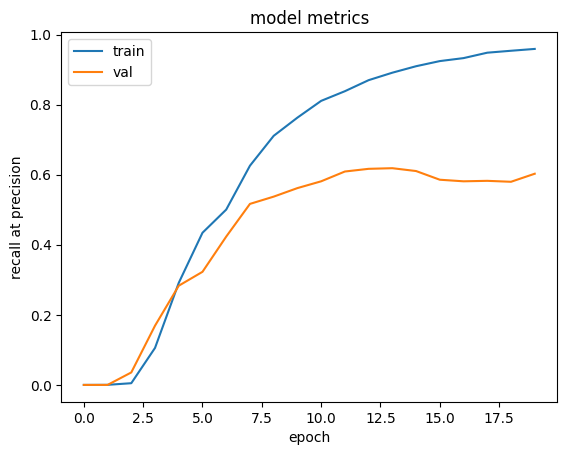

In [32]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Рекуррентные слои можно накладывать друг на друга. Нужно только указать параметр return_sequences=True, т.к. слой ожидает на вход последовательность. Длина последовательности не изменяется, поэтому можно совмещать сколько угодно слоев. Это называется stacked LSTM/GRU.

Основной параметр в LSTM/GRU слое - units. Чем он больше, тем больше весов будет в модели. Он будет соответствовать размеру вектора состояния (hidden_state). Он может быть любой даже при накладывании слоев друг на друга (они могут быть одинаковые как тут, первый может быть больше, второй может быть больше).

In [33]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = keras.layers.GRU(128, return_sequences=False)(lstm_1)

dense = keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [34]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 30)        │       722,790 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 200, 128)       │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 19)             │         1,235 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 912,761 (3.48 MB)

 Trainable params: 912,761 (3.48 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=200,
          epochs=15)

Epoch 1/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 148s 699ms/step - loss: 2.4180 - rec@prec: 8.1810e-05 - val_loss: 1.7612 - val_rec@prec: 0.0397
Epoch 2/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 154s 733ms/step - loss: 1.5459 - rec@prec: 0.1098 - val_loss: 1.1927 - val_rec@prec: 0.4337
Epoch 3/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 160s 758ms/step - loss: 1.0095 - rec@prec: 0.5730 - val_loss: 1.1259 - val_rec@prec: 0.5460
Epoch 4/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 160s 758ms/step - loss: 0.7695 - rec@prec: 0.7455 - val_loss: 1.0720 - val_rec@prec: 0.6073
Epoch 5/15
 10/211 ━━━━━━━━━━━━━━━━━━━━ 2:20 699ms/step - loss: 0.6399 - rec@prec: 0.8350

KeyboardInterrupt: 

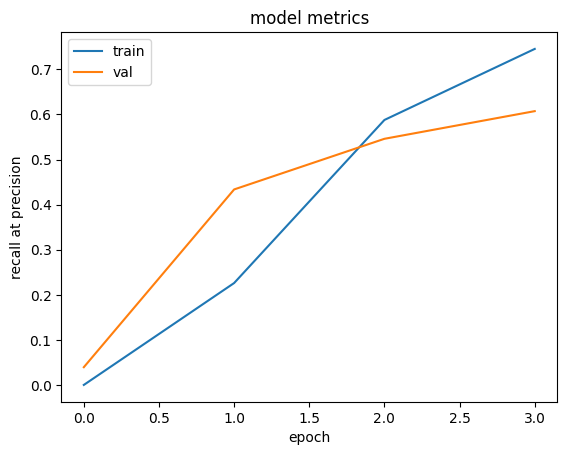

In [36]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Рекурретную сеть можно применить в прямом и обратном порядке и объединить состояния в одно (половина вектора будет про инфу до, половина про инфу после). Это назвается Bidirectional и делается в keras очень просто. 

In [38]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=False))(embeddings)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


Схема задачи, чтобы было понятнее.

![bilstm classification](./image_bilstm_clf.png)

In [39]:
model.summary()
# обратите внимание на размер output в biderectional
# он равен units * 2

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 200, 100)       │     2,409,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,648,679 (10.10 MB)

 Trainable params: 2,648,679 (10.10 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=200,
         epochs=5)

Epoch 1/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 124s 586ms/step - loss: 2.2686 - rec@prec: 0.0062 - val_loss: 1.9336 - val_rec@prec: 0.0162
Epoch 2/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 125s 594ms/step - loss: 1.7359 - rec@prec: 0.0495 - val_loss: 1.8858 - val_rec@prec: 0.1041
Epoch 3/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - loss: 1.7391 - rec@prec: 0.0959 - val_loss: 1.6266 - val_rec@prec: 0.0771
Epoch 4/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 164s 778ms/step - loss: 1.4073 - rec@prec: 0.2681 - val_loss: 1.7428 - val_rec@prec: 0.1677
Epoch 5/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 178s 842ms/step - loss: 1.3729 - rec@prec: 0.3524 - val_loss: 1.3247 - val_rec@prec: 0.4125


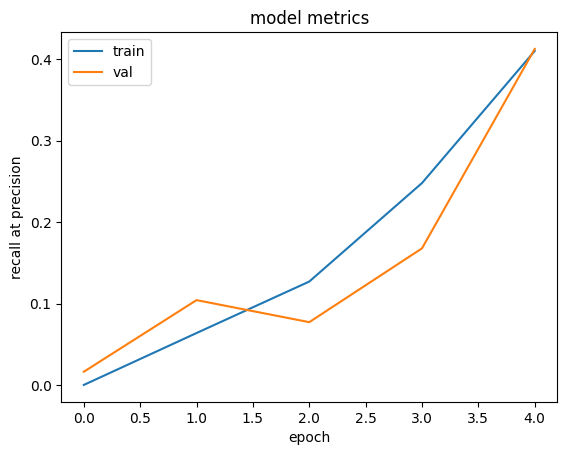

In [41]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NB: когда мы оборачиваем LSTM в Bidirectional, то этот слой применяется и напрямую и обратно. Кажется, что логичнее иметь один слой для прямого прогона и один для обратного.
В Bidirectional можно также указать отдельный backward_layer, чтобы использовался новый слой.

In [42]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

# 1 слой на 2 прогона вручную
# lstm = keras.layers.LSTM(128, return_sequences=False)
# lstm_forward = lstm(embeddings)
# lstm_backward = lstm(embeddings[::-1])

# 2 слоя вручную
lstm_forward =  keras.layers.LSTM(128, return_sequences=False)(embeddings)
lstm_backward =  keras.layers.LSTM(128, return_sequences=False, go_backwards=True)(embeddings)

hidden = keras.layers.concatenate([lstm_forward, lstm_backward])

# 2 слоя через Bidirectional
# hidden = keras.layers.Bidirectional(
#                                        keras.layers.LSTM(128, return_sequences=False),
#                         backward_layer=keras.layers.LSTM(128, return_sequences=False, 
#                                                             go_backwards=True))(embeddings)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [43]:
model.summary()
# обратите внимание на размер output в biderectional
# он равен units * 2

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 200, 100)  │  2,409,300 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │    117,248 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 128)       │    117,248 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 19)        │      4,883 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,648,679 (10.10 MB)

 Trainable params: 2,648,679 (10.10 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=200,
         epochs=10)

Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 158s 747ms/step - loss: 2.3474 - rec@prec: 8.1717e-06 - val_loss: 1.9513 - val_rec@prec: 0.0090
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 147s 697ms/step - loss: 1.9130 - rec@prec: 0.0029 - val_loss: 1.8059 - val_rec@prec: 0.0334
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 153s 722ms/step - loss: 1.6005 - rec@prec: 0.1076 - val_loss: 2.2274 - val_rec@prec: 0.0419
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 141s 668ms/step - loss: 1.4400 - rec@prec: 0.1686 - val_loss: 1.3343 - val_rec@prec: 0.3084
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 161s 765ms/step - loss: 1.1950 - rec@prec: 0.4057 - val_loss: 1.1789 - val_rec@prec: 0.4784
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 149s 707ms/step - loss: 1.0621 - rec@prec: 0.5585 - val_loss: 1.1777 - val_rec@prec: 0.4901
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 164s 776ms/step - loss: 0.9190 - rec@prec: 0.6704 - val_loss: 1.0938 - val_rec@prec: 0.5753
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 194s 919ms/step - loss: 0.8104 -

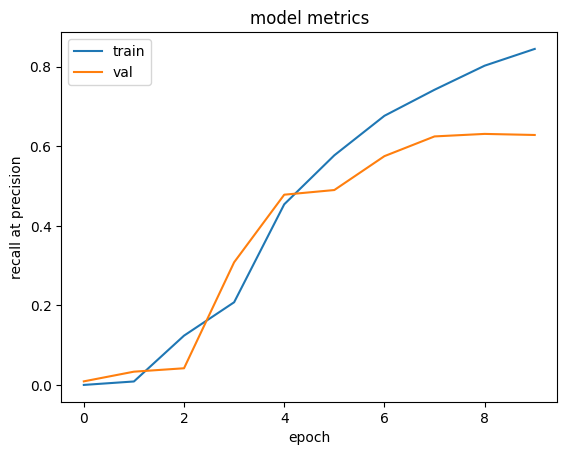

In [46]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Sequence labelling

На выходе из рекурректной сети получается по вектору на каждый элемент последовательности. Мы можем использовать только последний, если нам нужно просто классифицировать весь текст (на последнем состоянии по идее должна была накопиться информация о всей последовательности).

Кроме этого, мы можем классифицировать каждый элемент последовательности. Это называется sequence labelling (разметка последовательности). Под этот паттерн попадает предсказание части речи, определение именованных сущностей, определение опечаток и другие задачи, где длина обоих последовательностей совпадает.

Давайте попробуем выделять именованные сущности.

Данные возьмем из бибиотеки datasets (часть huggingface)

In [49]:
# !pip install datasets

In [50]:
from datasets import load_dataset

В этой библиотеке несколько датасетов для именованных сущностей. Мы возьмем датасет, собранный по википедии. Он мультиязычный, но для семинара мы возьмем только русскую часть.

In [54]:
dataset = load_dataset("tner/wikiann", 'ru')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset wikiann downloaded and prepared to /Users/mnefedov/.cache/huggingface/datasets/tner___wikiann/ru/1.1.0/39367cc2fcf8467e7d7d81fdd2e3b5277c3b0c003bbe7f3e5e4895a41a141507. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Датасет уже заранее разбит на трейн, валидацию и тест.

In [55]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
})

Пример данных

In [58]:
dataset['train']['tokens'][0], dataset['train']['tags'][0]

(['Илизаров', ',', 'Гавриил', 'Абрамович'], [2, 5, 5, 5])

Индексы в разметке соответствуют вот таким классам:

In [59]:
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG',  'B-LOC', 'I-LOC']

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

Что они значат?
![](https://editor.analyticsvidhya.com/uploads/19617Intro%20image.jpg)


**PER, ORG, LOC** - это типы именованных сущностей, Person, Organization и Location. Это стандартные типы сущностей, которые чаще всего приходится выделять. Оценочные датасеты обычно размечены этими типами. Другие популярные сущности - номера телефонов, числа, имейлы, дата, время, но их обычно определяют правилами (регулярками например).

**I, B** - эта часть тэга показывает в какой части именованной сущности находится токен. **B - beggining** (начало), **I - inside** (внутри, т.е. после начала).

**O** - это отрицательный класс (outside или other), т.е. несущность.

Такую разметку назвают IOB, она помогает точнее определять сущности и различать рядом стоящие сущности одного типа. Есть и другие типы (например, BILOU - L означает last, последний токен в сущности, а U - unit, сущность из 1 токена). 

Именованной сущностью в принципе можно считать любую последовательность токенов, которую нужно выделить из текста. В биоинформатике, например, сущностями считаются белки, гены, препараты, заболевания, а при разборе научных статей можно выделять цитаты, ключевые метрики, методы (используемые алгоритмы и модели). 

Для того, чтобы извлекать специфичные типы сущностей вам скорее всего придется либо а) самому размечать данные, либо б) создавать словари, правила и грамматики. А скорее всего и то, и другое. Сущности, размеченные моделью обычно еще нужно привести к стандартному виду и делается это в большинстве случаев маппингом на словарь стандартных форм (например, Вышка, ВШЭ, вше, НИУВШЭ, Высшая школа экономики -> НИУ ВШЭ). Маппинг можно делать с помощью простого словаря или с помощью какой-нибудь функции близости (например, расстояния редактирования).

С помощью правил также можно размечать данные и обучать на этом более сложные модели (в надежде, что сложные модели запомнят разметку и дополнительно научатся обобщать). Такой подход называется weak labelling/weak supervision. Для этого есть такие библиотеки: [Snorkel](https://www.snorkel.org/) , [Rubrix](https://github.com/recognai/rubrix)

Для создания грамматик на русском языке можно использовать [Tomita Parser](https://yandex.ru/dev/tomita/), [Yargy](https://github.com/natasha/yargy). Томита быстрее, но сложнее в использовании (внутри там майстем). Yargy написан на питоне и его проще освоить, внутри там пайморфи. В тетрадке NER_rule_based.ipynb (лежит в этой же папке) есть пример написания грамматик на Yargy. 

Давайте посмотрим, как обучать модели, когда разметка уже есть

In [60]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [61]:
# тут словарь не очень большой и тут нужно предсказывать тэги для всех слов
# поэтому не будем фильтровать словарь
len(vocab)

36015

In [62]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [63]:
id2word = {i:word for word, i in word2id.items()}

In [64]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [65]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [66]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

Теги уже переведены в индексы, но обратный маппинг мы тоже сделаем, чтобы дальше удобнее было проверять работу модели. 
Длина последовательностей тегов должна совпадать с длиной последовательностей токенов, поэтому тут тоже нужно сделать паддинг, но в этом случае мы не можем паддить нулями, т.к. ноль у нас уже забронирован тэгом O. Добавим дополнительный тэг пад и будем использовать его индекс при паддинге (value=7)

In [67]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [68]:
y = keras.preprocessing.sequence.pad_sequences(dataset['train']['tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = keras.preprocessing.sequence.pad_sequences(dataset['test']['tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

Схема задачи, чтобы было понятнее, что мы предсказываем:
![](image_seq_labelling.png)

In [69]:
X.shape, X_test.shape

((20000, 54), (10000, 54))

In [70]:
y.shape, y_test.shape

((20000, 54), (10000, 54))

In [71]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm_1)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
             metrics=['accuracy'])


In [72]:
model.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 37s 234ms/step - accuracy: 0.8877 - loss: 0.5748 - val_accuracy: 0.9490 - val_loss: 0.1677
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - accuracy: 0.9547 - loss: 0.1456 - val_accuracy: 0.9719 - val_loss: 0.0934
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 66s 424ms/step - accuracy: 0.9790 - loss: 0.0700 - val_accuracy: 0.9806 - val_loss: 0.0627
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 280ms/step - accuracy: 0.9913 - loss: 0.0331 - val_accuracy: 0.9830 - val_loss: 0.0546
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 33s 209ms/step - accuracy: 0.9961 - loss: 0.0165 - val_accuracy: 0.9833 - val_loss: 0.0539


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


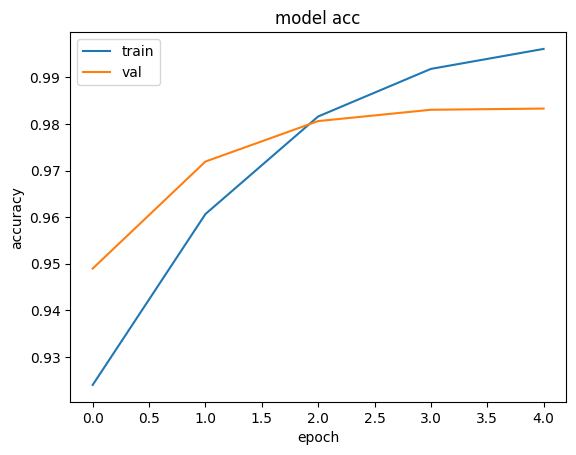

In [73]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Оценивать предсказания последовательностей нужно отдельно. Лучше конечно еще оценивать правильность всей последовательности, но пока сделаем только поэлементную оценку.

In [74]:
from sklearn.metrics import classification_report

In [75]:
pred = model.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step


In [76]:
pred

array([[6, 6, 1, ..., 7, 7, 7],
       [6, 6, 4, ..., 7, 7, 7],
       [6, 6, 6, ..., 7, 7, 7],
       ...,
       [2, 5, 5, ..., 7, 7, 7],
       [1, 4, 4, ..., 7, 7, 7],
       [6, 6, 6, ..., 7, 7, 7]])

In [77]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.85      0.64      0.73      4560
       B-PER       0.60      0.77      0.68      4074
       I-PER       0.82      0.83      0.83      3542
       B-ORG       0.88      0.72      0.79      3060
       I-ORG       0.77      0.77      0.77      8008
       B-LOC       0.85      0.89      0.87      7544
       I-LOC       0.94      0.94      0.94     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.84      0.82      0.83    540000
weighted avg       0.98      0.98      0.98    540000



# Предсказание/Inference

После оценки часто хочется посмотреть как будет работать модель на каких-то отдельных примерах. Для этого нужно воспрозвести весь пайплайн и прогонять через него нужный текст.

In [78]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [79]:
label_seq('Алексей сказал Светлане, чтобы она собиралась на поезд в Москву.', word2id, id2labels, MAX_LEN, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


[('Алексей', 'I-PER'),
 ('сказал', 'I-LOC'),
 ('Светлане', 'B-LOC'),
 (',', 'I-LOC'),
 ('чтобы', 'I-LOC'),
 ('она', 'I-LOC'),
 ('собиралась', 'I-LOC'),
 ('на', 'I-LOC'),
 ('поезд', 'I-LOC'),
 ('в', 'I-LOC'),
 ('Москву', 'O'),
 ('.', 'I-LOC')]

In [80]:
label_seq('Я поступил в ВШЭ в Питер', word2id, id2labels, MAX_LEN, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


[('Я', 'I-LOC'),
 ('поступил', 'I-LOC'),
 ('в', 'I-LOC'),
 ('ВШЭ', 'I-LOC'),
 ('в', 'I-LOC'),
 ('Питер', 'B-LOC')]

In [82]:
label_seq('Виктор, Семен, Петр, Арагорн, Осел', word2id, id2labels, MAX_LEN, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


[('Виктор', 'I-PER'),
 (',', 'B-LOC'),
 ('Семен', 'B-LOC'),
 (',', 'B-LOC'),
 ('Петр', 'B-LOC'),
 (',', 'I-LOC'),
 ('Арагорн', 'I-PER'),
 (',', 'I-LOC'),
 ('Осел', 'I-LOC')]